In [1]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, confusion_matrix
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
from matplotlib.colors import Normalize

## Data loading and prep

In [2]:
model_type = 'all'

In [3]:
MAIN_PATH = '/itet-stor/kvulic/neuronies/single_neurons/3_Student_Projects/Amelie/Processed_data/'
OUTPUT_PATH = os.path.join(MAIN_PATH, f'Results+{model_type}')
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [4]:
DIVs = [27, 28, 32, 35, 42]
Chip_ID_ngn2 = ['1908','1765','1821']
Chip_ID_gaba = ['2034','2074']

#dataset = f"/Volumes/violam/neuronies/single_neurons/3_Student_Projects/Amelie/Datasets/DIVS{DIVs}_full_dataset.csv"
dataset = os.path.join(MAIN_PATH, 'Results/extremum_results_final.pkl')
df_original = pd.read_pickle(dataset)
df = df_original[df_original['cell_type'] != 'CoCulture']

In [5]:
df.dropna(inplace = True)
df['chip_id'].unique()

/tmp/ipykernel_17819/265236915.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


array(['2034', '1908', '1821', '1765', '2074', '1708'], dtype=object)

## Create differnt datasets for testing

In [6]:
#take only chips '2034', '2074', '1908', '1821' and use isin method
df = df[df['chip_id'].isin([Chip_ID_ngn2[0], Chip_ID_ngn2[1], Chip_ID_gaba[0], Chip_ID_gaba[1]])]

#make column Type that is 0 if cell_type == NGN2 and 1 if cell_type == GABA
df['Type'] = df['cell_type'].apply(lambda x: 0 if x == 'NGN2' else 1)
df

,filename,chip_id,area,div,electrode,unit_idx,unit_id,data_type,firing_rate,isi_mean,...,peak_trough_ratio,repolarization_slope,recovery_slope,half_width,peak_idx,trough_idx,amplitude uV,template,speed_ms-1,Type
22,ID2034_N3_DIV35_DATE20241127_1544_spontaneous_...,2034,3,35,7074,27,29,SPIKEMAT_EXTREMUM,3.528320,284.459158,...,0.086088,-272887.939453,0.000000,0.40,79,49,143.816742,"[-6.314716, -6.63426, -7.2937217, -8.56234, -1...",1.419311,1
23,ID2034_N3_DIV35_DATE20241127_1544_spontaneous_...,2034,3,35,9256,18,19,SPIKEMAT_EXTREMUM,2.033483,494.899363,...,0.284248,-268083.740234,-42660.037994,0.30,54,40,148.376755,"[6.687971, 6.791456, 6.7550836, 6.835834, 6.95...",0.528231,1
24,ID2034_N3_DIV35_DATE20241127_1544_spontaneous_...,2034,3,35,6420,30,32,SPIKEMAT_EXTREMUM,1.507604,669.022414,...,0.134037,-185450.546265,-13119.379997,0.15,63,40,99.213623,"[-0.026687747, -0.15761572, -0.006503847, 1.00...",0.942404,1
25,ID2034_N3_DIV35_DATE20241127_1544_spontaneous_...,2034,3,35,13216,23,24,SPIKEMAT_EXTREMUM,4.588149,218.568503,...,0.261754,-426294.647217,-36261.528015,0.30,62,40,237.855667,"[5.728044, 6.5891643, 7.773545, 9.744434, 11.7...",1.406983,1
26,ID2034_N3_DIV35_DATE20241127_1544_spontaneous_...,2034,3,35,9026,9,9,SPIKEMAT_EXTREMUM,1.656200,608.546063,...,0.157318,-200083.587646,-26335.556030,0.35,67,40,102.549576,"[-1.3907224, -1.3382281, -1.6187385, -2.394037...",0.351213,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21752,ID1765_N0_DIV49_DATE20241108_1016_spontaneous_...,1765,0,49,15437,3,11,SPIKEMAT_EXTREMUM,0.781105,1304.392453,...,0.379122,-574265.014648,-170629.669189,0.25,49,40,300.761230,"[-0.022627389, 0.5893635, 1.3431509, 1.5283918...",0.413231,0
21753,ID1765_N0_DIV49_DATE20241108_1016_spontaneous_...,1765,0,49,8610,2,9,SPIKEMAT_EXTREMUM,3.805586,263.763208,...,0.127528,-427096.679688,-10715.694427,0.35,65,40,215.998138,"[-6.268952, -6.728142, -6.5936084, -6.0189147,...",0.350348,0
21754,ID1765_N0_DIV49_DATE20241108_1016_spontaneous_...,1765,0,49,14993,6,16,SPIKEMAT_EXTREMUM,1.376135,734.322105,...,0.228397,-134798.950195,-7238.524437,0.35,57,40,67.399475,"[-1.4445795, -0.31602663, 1.3166906, 1.586288,...",0.267157,0
21755,ID1765_N0_DIV49_DATE20241108_1016_spontaneous_...,1765,0,49,14553,5,15,SPIKEMAT_EXTREMUM,0.984322,1031.090299,...,0.047772,-471414.733887,-9284.446716,0.15,64,40,282.733643,"[0.93760747, 1.8134977, 2.2106574, 2.2346528, ...",0.444945,0


In [7]:
df = df[(df['div'].astype(int).isin(DIVs))]
df['div'].unique()

array(['35', '28', '27', '42'], dtype=object)

In [8]:
#df_relevant = df[['Peak-to-Trough', 'Half-width', 'Repolarization slope', 'Recovery slope', 'Conduction Speed', 'FR', 'ISIstd', 'Mean_Amplitude']].copy()
#df_waveform_metrics = df[['Peak-to-Trough', 'Half-width', 'Repolarization slope', 'Recovery slope']].copy()
#df_firing_metrics = df[['Conduction Speed', 'FR', 'ISIstd', 'Mean_Amplitude']].copy()

df_relevant = df[['firing_rate', 'peak_trough_ratio', 'peak_to_trough_duration', 'half_width', 'repolarization_slope', 'recovery_slope', 'speed_ms-1', 'isi_std', 'amplitude uV']].copy()
df_waveform_metrics = df[['peak_trough_ratio', 'peak_to_trough_duration', 'half_width', 'repolarization_slope', 'recovery_slope']].copy()
df_firing_metrics = df[['speed_ms-1', 'firing_rate', 'isi_std', 'amplitude uV']].copy()
df_relevant = df_relevant

In [9]:
X = df_relevant
y = df['Type']

# Convert DataFrame to PyTorch tensors
X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32)
y_tensor = torch.tensor(y.to_numpy(), dtype=torch.float32)

# Split the data into train and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size= 0.3, random_state=42, stratify=y_tensor)

# Split the data into train and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size= 0.5, random_state=42, stratify=y_temp)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
standardized_X_train = scaler.fit_transform(X_train)
standardized_X_val= scaler.transform(X_val)
standardized_X_test= scaler.transform(X_test)

standardized_X_train_tensor = torch.tensor(standardized_X_train, dtype=torch.float32)
standardized_X_val_tensor = torch.tensor(standardized_X_val, dtype=torch.float32)
standardized_X_test_tensor = torch.tensor(standardized_X_test, dtype=torch.float32)

print(f'Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}')
print(standardized_X_train_tensor.shape)

Train: 3248, Validation: 696, Test: 696
torch.Size([3248, 9])


## Define the locally sparse model

In [10]:
class LLSPIN(nn.Module):
    def __init__(self, input_node, hidden_layers_node, output_node, gating_net_hidden_layers_node, 
                 feature_selection=True, activation_pred='none', activation_gating='tanh'):
        super(LLSPIN, self).__init__()

        dropout_rate = 0.4
        # Prediction network
        layers = []
        in_features = input_node
        for out_features in hidden_layers_node:
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU())  # Activation
            layers.append(nn.Dropout(dropout_rate))
            in_features = out_features
        layers.append(nn.Linear(in_features, output_node))
        if activation_pred == 'none':
            pass  # No activation for linear output
        self.prediction_net = nn.Sequential(*layers)
        
        # Gating network
        self.feature_selection = feature_selection
        if feature_selection:
            gating_layers = []
            in_features = input_node
            for out_features in gating_net_hidden_layers_node:
                gating_layers.append(nn.Linear(in_features, out_features))
                if activation_gating == 'tanh':
                    gating_layers.append(nn.Tanh())
                elif activation_gating == 'relu':
                    gating_layers.append(nn.ReLU())
                gating_layers.append(nn.Dropout(dropout_rate))
                in_features = out_features
            gating_layers.append(nn.Linear(in_features, input_node))  # Output gating mask
            self.gating_net = nn.Sequential(*gating_layers)
        
    def forward(self, x):
        if self.feature_selection:
            gating_mask = torch.sigmoid(self.gating_net(x))  # Sparsity enforced via sigmoid
            x = x * gating_mask  # Apply gating mask
        
        y_pred = self.prediction_net(x)
        return y_pred

In [11]:
# Class weights
num_positive = y_train.sum()
num_negative = len(y_train) - num_positive
pos_weight = num_negative / num_positive  # Calculate the positive class weight
pos_weight


tensor(4.8628)

In [12]:
# Hyperparameters
model_params = {
    "input_node": standardized_X_train_tensor.shape[1],
    "hidden_layers_node": [512, 256, 128, 64],
    "output_node": 1,
    "gating_net_hidden_layers_node": [32 ,16],
    "feature_selection": True,
    "activation_pred": 'none',
    "activation_gating": 'tanh',
}

In [13]:
# Initialize Model
model = LLSPIN(**model_params)

## Train the locally sparse model and observed performance on validation set

In [14]:
# Initialize Model
model = LLSPIN(**model_params)

# Training Setup
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2))  # Use BCEWithLogits for binary classification
# optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
optimizer = torch.optim.SGD(model.parameters(), lr=2e-4, weight_decay=1.5e-4, momentum=0.9)

batch_size =64  # or try 32, 128 depending on your available memory

# DataLoader for batching
train_dataset = TensorDataset(standardized_X_train_tensor, torch.tensor(y_train, dtype=torch.float32))
# train_loader = DataLoader(train_dataset, batch_size=standardized_X_train.shape[0], shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(standardized_X_val_tensor, torch.tensor(y_val, dtype=torch.float32))
# val_loader = DataLoader(val_dataset, batch_size=standardized_X_val.shape[0], shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Early Stopping Parameters
patience = 20  # Number of epochs to wait before stopping if no improvement
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
best_val_loss = float('inf')  # Initialize the best validation loss as infinity
early_stop_counter = 0  # Counter for early stopping

num_epochs = 5000
val_check_interval = 5  # Check validation every 10 epochs

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for batch_x, batch_y in train_loader:
        outputs = model(batch_x).squeeze()
        loss = criterion(outputs, batch_y)

        # Add sparsity regularization
        if model.feature_selection:
            l1_reg = sum(torch.sum(torch.abs(param)) for param in model.gating_net.parameters())
            # loss += lam * l1_reg

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (predictions == batch_y).sum().item()
        total_train += batch_y.size(0)

    epoch_train_loss /= len(train_loader)
    epoch_train_accuracy = correct_train / total_train

    # Append training metrics
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)   

    # Track validation performance every `val_check_interval` epochs
    if epoch % val_check_interval == 0:
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x).squeeze()
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                predictions = (torch.sigmoid(outputs) > 0.5).float()
                correct_val += (predictions == batch_y).sum().item()
                total_val += batch_y.size(0)

        val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val

        # Validation phase
        if epoch % val_check_interval == 0:
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            
        print(f"Epoch {epoch}/{num_epochs}: Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        # Early Stopping Logic
        if val_loss < best_val_loss - min_delta:  # Improvement in validation loss
            best_val_loss = val_loss
            early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            early_stop_counter += 1  # Increment counter if no improvement

        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}. Best Val Loss: {best_val_loss:.4f}")
            break  # Stop training if no improvement for `patience` epochs
        
    #lr_scheduler.step()


/tmp/ipykernel_17819/3289184169.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(standardized_X_train_tensor, torch.tensor(y_train, dtype=torch.float32))
/tmp/ipykernel_17819/3289184169.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_dataset = TensorDataset(standardized_X_val_tensor, torch.tensor(y_val, dtype=torch.float32))
/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/torch/autograd/graph.py:824: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Down

Epoch 0/5000: Train Loss: 0.7974, Train Acc: 0.8239, Val Loss: 0.7940, Val Acc: 0.8290
Epoch 5/5000: Train Loss: 0.7687, Train Acc: 0.8294, Val Loss: 0.7660, Val Acc: 0.8290
Epoch 10/5000: Train Loss: 0.7502, Train Acc: 0.8294, Val Loss: 0.7470, Val Acc: 0.8290
Epoch 15/5000: Train Loss: 0.7366, Train Acc: 0.8294, Val Loss: 0.7338, Val Acc: 0.8290
Epoch 20/5000: Train Loss: 0.7262, Train Acc: 0.8294, Val Loss: 0.7245, Val Acc: 0.8290
Epoch 25/5000: Train Loss: 0.7202, Train Acc: 0.8294, Val Loss: 0.7179, Val Acc: 0.8290
Epoch 30/5000: Train Loss: 0.7155, Train Acc: 0.8294, Val Loss: 0.7132, Val Acc: 0.8290
Epoch 35/5000: Train Loss: 0.7122, Train Acc: 0.8294, Val Loss: 0.7097, Val Acc: 0.8290
Epoch 40/5000: Train Loss: 0.7104, Train Acc: 0.8294, Val Loss: 0.7072, Val Acc: 0.8290
Epoch 45/5000: Train Loss: 0.7070, Train Acc: 0.8294, Val Loss: 0.7051, Val Acc: 0.8290
Epoch 50/5000: Train Loss: 0.7071, Train Acc: 0.8294, Val Loss: 0.7035, Val Acc: 0.8290
Epoch 55/5000: Train Loss: 0.7044,

## Save the model

In [379]:
model_state_dict = os.path.join(OUTPUT_PATH, f'LLSPIN_model_state_dict_{model_type}.pth')

#torch.save(model.state_dict(), model_state_dict)  # Save only the model's state_dict

# Save the model
torch.save(model.state_dict(), model_state_dict)

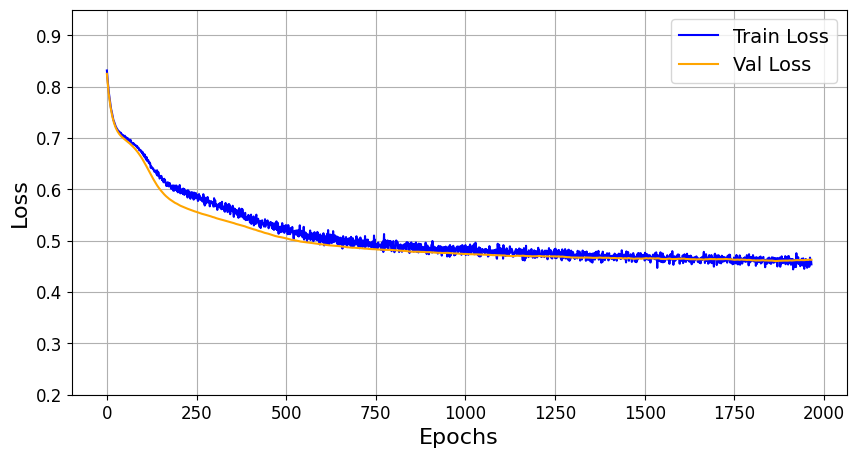

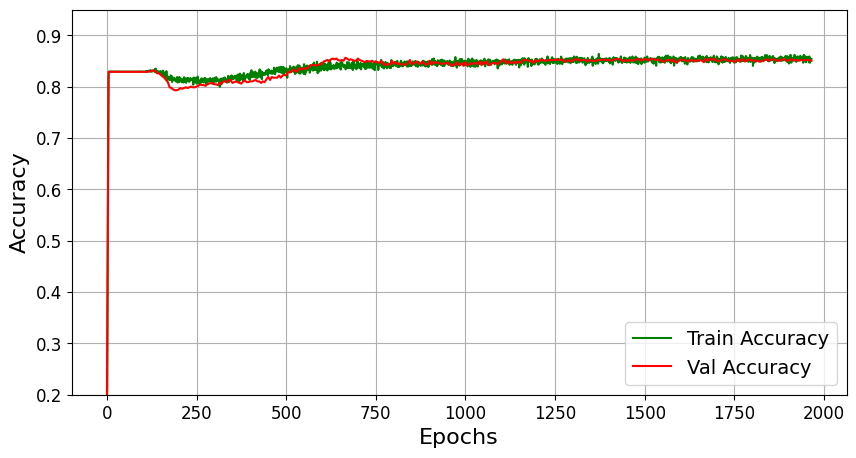

In [380]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.ylim(0.2, 0.95)

plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(range(0, len(val_losses) * val_check_interval, val_check_interval), val_losses, label='Val Loss', color='orange')
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
#plt.title('Training and Validation Loss')
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.ylim(0.2, 0.95)

plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(0, len(val_accuracies) * val_check_interval, val_check_interval), val_accuracies, label='Val Accuracy', color='red')
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
#plt.title('Training and Validation Accuracy')
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.grid()
plt.savefig(os.path.join(OUTPUT_PATH, f'LLSPIN_training_validation_accuracy_{model_type}.png'), dpi=300)
plt.savefig(os.path.join(OUTPUT_PATH, f'LLSPIN_training_validation_accuracy_{model_type}.pdf'), dpi=300, format = 'pdf')



plt.show()


In [15]:
model_state_dict = os.path.join(OUTPUT_PATH,f'LLSPIN_model_state_dict_{model_type}.pth')
model.load_state_dict(torch.load(model_state_dict))

<All keys matched successfully>

## Verification on the test set

tensor([[-1.5405],
        [-0.7480],
        [-0.4556],
        [-2.8616],
        [-2.8843],
        [-2.5035],
        [-3.1895],
        [-3.5822],
        [ 1.1355],
        [-1.7532],
        [-3.1767],
        [-3.0622],
        [-2.8562],
        [-3.0230],
        [ 1.9614],
        [-4.6281],
        [-1.7715],
        [-1.3293],
        [-3.1422],
        [-2.2367],
        [-4.0033],
        [-1.9474],
        [-1.4983],
        [-1.9064],
        [-2.3050],
        [ 1.0694],
        [ 1.3170],
        [ 0.5020],
        [ 0.2765],
        [-3.4302],
        [-1.4034],
        [-2.8999],
        [-3.9665],
        [-1.6269],
        [-0.4291],
        [-3.9192],
        [-3.9764],
        [-3.0628],
        [-2.1955],
        [-4.6665],
        [ 0.3453],
        [-3.5322],
        [ 1.2042],
        [-2.9268],
        [-0.5502],
        [-2.1168],
        [-1.6184],
        [-3.3509],
        [-2.7559],
        [-2.9458],
        [-3.8338],
        [-4.0894],
        [-4.

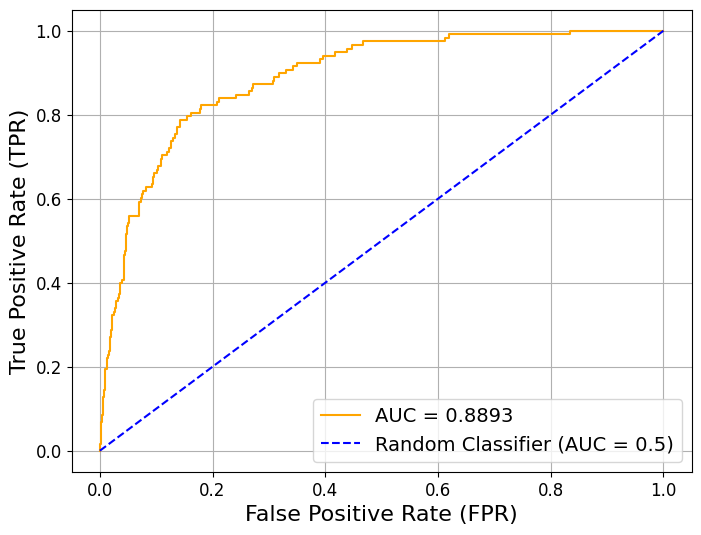

In [382]:
from sklearn.metrics import roc_auc_score, roc_curve

# set model to evaluation state
model.eval()

standardized_X_tensor = torch.tensor(standardized_X_test, dtype=torch.float32)

# Predict on the new dataset
with torch.no_grad():
    y_pred_test = model(standardized_X_tensor)
    print(y_pred_test)
    probabilities = torch.sigmoid(y_pred_test)
    print(probabilities)
    auc_score = roc_auc_score(y_test, y_pred_test)

    y_pred_test_labels = (probabilities > 0.5).int()

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred_test_labels)

print(f'Accuracy: {accuracy:.4f}')

# Compute ROC Curve (FPR, TPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label="Random Classifier (AUC = 0.5)")
# plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate (FPR)", fontsize = 16)
plt.ylabel("True Positive Rate (TPR)", fontsize = 16)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid()
plt.savefig(os.path.join(OUTPUT_PATH, f'LLSPIN_ROC_curve_{model_type}.png'), dpi=300)
plt.savefig(os.path.join(OUTPUT_PATH, f'LLSPIN_ROC_curve_{model_type}.pdf'), dpi=300, format = 'pdf')
plt.show()


Training Set:
              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91      2694
         1.0       0.57      0.71      0.64       554

    accuracy                           0.86      3248
   macro avg       0.76      0.80      0.78      3248
weighted avg       0.88      0.86      0.87      3248

Validation Set:
              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91       577
         1.0       0.55      0.68      0.61       119

    accuracy                           0.85       696
   macro avg       0.74      0.78      0.76       696
weighted avg       0.87      0.85      0.86       696

Test Set:
              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91       578
         1.0       0.56      0.69      0.62       118

    accuracy                           0.86       696
   macro avg       0.75      0.79      0.76       696
weighted avg       0.87      0.86 

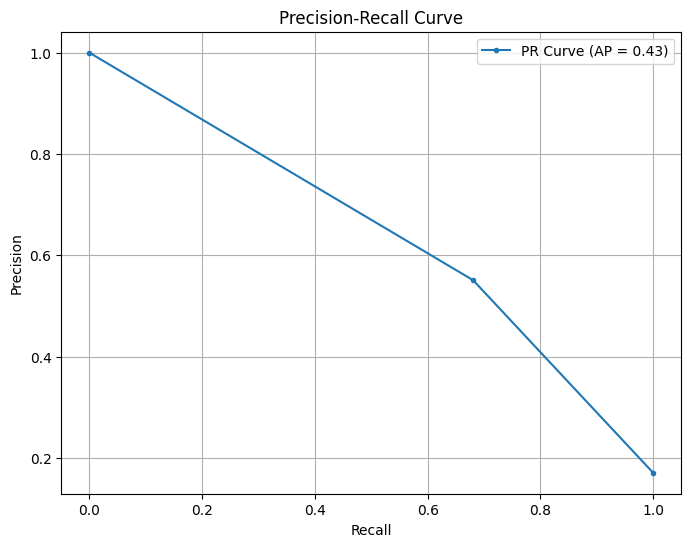

In [383]:
# Convert logits to predictions
y_pred_train = (torch.sigmoid(model(standardized_X_train_tensor)).detach().cpu().numpy() > 0.5).astype(int)
y_pred_val = (torch.sigmoid(model(standardized_X_val_tensor)).detach().cpu().numpy() > 0.5).astype(int)
y_pred_test = (torch.sigmoid(model(standardized_X_test_tensor)).detach().cpu().numpy() > 0.5).astype(int)

# Print classification reports
print("Training Set:")
report_train = classification_report(y_train, y_pred_train)
print(report_train)

print("Validation Set:")
report_val = classification_report(y_val, y_pred_val)
print(report_val)

print("Test Set:")
report_test = classification_report(y_test, y_pred_test)
print(report_test)

# Save to a text file
with open(os.path.join(OUTPUT_PATH,"classification_report_train.txt"), "w") as f:
    f.write(report_train)
with open(os.path.join(OUTPUT_PATH,"classification_report_val.txt"), "w") as f:
    f.write(report_val)
with open(os.path.join(OUTPUT_PATH,"classification_report_test.txt"), "w") as f:
    f.write(report_test)

print('Classification reports saved successfully')

from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_val)

# Compute Average Precision (AP) Score
ap_score = average_precision_score(y_val, y_pred_val)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'PR Curve (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


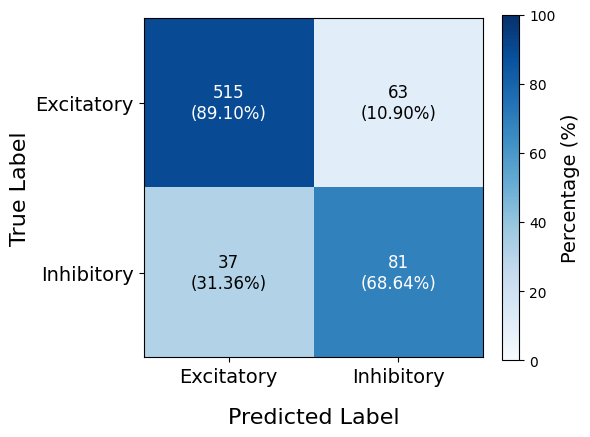

In [384]:
# Calculate confusion matrix
cm = confusion_matrix(y_test.numpy(), y_pred_test_labels.squeeze())

# Normalize to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

# Normalize the confusion matrix for text color mapping
norm = Normalize(vmin=0, vmax=100)  # Ensure min is 0

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm_percentage, interpolation='nearest', cmap='Blues', norm = norm)  # Use the Blues colormap

# Add a color bar
cbar = plt.colorbar(im, ax=ax, fraction = 0.046)
cbar.set_ticks([0, 20, 40, 60, 80, 100])  # Ensure it runs from 0 to 100
cbar.set_label("Percentage (%)", fontsize=14)

# Set axis labels and titles
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))
ax.set_xticklabels(['Excitatory', 'Inhibitory'], fontsize = 14)
ax.set_yticklabels(['Excitatory', 'Inhibitory'], fontsize = 14)
plt.xlabel('Predicted Label', fontsize = 16, labelpad = 15)
plt.ylabel('True Label', fontsize = 16)
#plt.title('Confusion Matrix')

# Normalize the confusion matrix for text color mapping
norm = Normalize(vmin=0, vmax=100)  # Ensure min is 0

# Annotate the confusion matrix with numbers and percentages
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        raw_count = cm[i, j]
        percent = cm_percentage[i, j]
        text = f"{raw_count}\n({percent:.2f}%)"
        
        # Get the RGBA color from the colormap
        rgba = im.cmap(norm(percent))  # Ensure it returns an RGBA tuple
        
        if isinstance(rgba, tuple) and len(rgba) == 4:
            r, g, b, _ = rgba  # Extract RGB values
        else:
            print(f"Unexpected colormap output at ({i},{j}):", rgba)
            continue  # Skip this iteration if color extraction fails
        
        # Calculate brightness (luminance)
        brightness = 0.299 * r + 0.587 * g + 0.114 * b  # Perceived brightness
        
        # Choose text color based on brightness
        font_color = "black" if brightness > 0.5 else "white"
        
        # Place the text with the determined font color
        ax.text(j, i, text, ha='center', va='center', color=font_color, fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, f'LLSPIN_confusion_matrix_test_{model_type}.png'), dpi=300)
plt.savefig(os.path.join(OUTPUT_PATH, f'LLSPIN_confusion_matrix_test_{model_type}.pdf'), dpi=300, format = 'pdf')
plt.show()




## New chip, hardcore test

In [385]:
#dataset_path_1742 = f"/Volumes/violam/neuronies/single_neurons/3_Student_Projects/Amelie/Datasets/Chip1742/Chip1742_all.csv"
df = df_original[df_original['cell_type'] != 'CoCulture']
eval_divs = [28, 32, 35, 42]

df_all_eval = df[df['chip_id'].isin([Chip_ID_ngn2[2]])]
df_all_eval = df_all_eval[df_all_eval['div'].astype(int).isin(eval_divs)]

df_all_eval['Type'] = df_all_eval['cell_type'].apply(lambda x: 0 if x == 'NGN2' else 1)


#df_1742 = pd.read_csv(dataset_path_1742)
#df_1742_divs = df_1742[df_1742['DIV'].isin(eval_divs)]

#df_all_eval = pd.concat([df_1742_divs], ignore_index=True)

df_all_eval 

,filename,chip_id,area,div,electrode,unit_idx,unit_id,data_type,firing_rate,isi_mean,...,peak_trough_ratio,repolarization_slope,recovery_slope,half_width,peak_idx,trough_idx,amplitude uV,template,speed_ms-1,Type
184,ID1821_N1_DIV28_DATE20241213_1401_spontaneous_...,1821,1,28,9983,48,49,SPIKEMAT_EXTREMUM,4.977221,201.408968,...,0.180423,-5.462251e+05,0.000000,0.75,79,40,289.195251,"[-33.26485, -33.641827, -33.96375, -33.517414,...",0.439682,0
185,ID1821_N1_DIV28_DATE20241213_1401_spontaneous_...,1821,1,28,8902,29,29,SPIKEMAT_EXTREMUM,1.663485,605.736641,...,0.025465,-7.179287e+05,0.000000,0.55,79,52,423.085938,"[-14.944752, -17.209265, -19.719522, -21.59005...",0.543242,0
186,ID1821_N1_DIV28_DATE20241213_1401_spontaneous_...,1821,1,28,5147,49,50,SPIKEMAT_EXTREMUM,1.731770,581.539362,...,0.075717,-6.083432e+05,0.000000,0.70,79,57,682.189697,"[-97.542175, -102.537285, -107.90076, -111.680...",0.443792,0
187,ID1821_N1_DIV28_DATE20241213_1401_spontaneous_...,1821,1,28,8491,7,7,SPIKEMAT_EXTREMUM,3.001825,334.490408,...,0.100946,-1.242271e+06,0.000000,0.45,75,38,621.135681,"[-46.481735, -47.626163, -48.348206, -48.13059...",0.741441,0
188,ID1821_N1_DIV28_DATE20241213_1401_spontaneous_...,1821,1,28,9114,91,95,SPIKEMAT_EXTREMUM,2.403967,418.090609,...,0.015096,-1.075525e+06,0.000000,0.70,79,49,537.762634,"[-39.64026, -41.89094, -43.70815, -44.768166, ...",0.935154,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16934,ID1821_N5_DIV28_DATE20241213_1401_spontaneous_...,1821,5,28,19017,65,69,SPIKEMAT_EXTREMUM,0.265223,3979.883333,...,0.436520,-3.831024e+05,-41422.111511,0.70,57,29,207.274155,"[8.727063, 13.051854, 18.158854, 22.83989, 29....",0.964485,0
16935,ID1821_N5_DIV28_DATE20241213_1401_spontaneous_...,1821,5,28,19683,67,71,SPIKEMAT_EXTREMUM,0.852156,1195.225926,...,0.534309,-6.409637e+05,-344523.498535,0.25,47,40,351.193268,"[-29.336674, -30.403488, -31.738413, -33.18201...",0.297443,0
16936,ID1821_N5_DIV28_DATE20241213_1401_spontaneous_...,1821,5,28,20550,101,106,SPIKEMAT_EXTREMUM,0.573767,1791.280556,...,0.189292,-1.182733e+06,-80731.201172,0.35,62,40,591.434570,"[-40.04214, -34.373672, -30.698256, -27.52504,...",1.109867,0
16937,ID1821_N5_DIV28_DATE20241213_1401_spontaneous_...,1821,5,28,19913,91,96,SPIKEMAT_EXTREMUM,1.094950,925.794521,...,0.266694,-2.668874e+05,-40094.371796,0.40,69,43,430.126465,"[-17.162712, -16.388079, -15.958659, -16.78125...",0.467989,0


In [389]:
df_relevant_eval = df_all_eval[['firing_rate', 'peak_trough_ratio', 'peak_to_trough_duration', 'half_width', 'repolarization_slope', 'recovery_slope', 'speed_ms-1', 'isi_std', 'amplitude uV']].copy()
# , 'Peak-to-Trough', 'Half-width', 'Repolarization slope', 'Recovery slope'
# , 'Conduction Speed', 'FR', 'ISIstd', 'Mean_Amplitude'
df_relevant_eval.replace('', np.nan, inplace=True)
df_relevant_eval.dropna(inplace = True)


df_waveform_metrics_eval = df_relevant_eval[['peak_trough_ratio', 'peak_to_trough_duration', 'half_width', 'repolarization_slope', 'recovery_slope']].copy()
df_firing_metrics_eval = df_relevant_eval[['speed_ms-1', 'firing_rate', 'isi_std', 'amplitude uV']].copy()


df_relevant_eval = df_firing_metrics_eval
df_relevant_eval

,speed_ms-1,firing_rate,isi_std,amplitude uV
184,0.439682,4.977221,429.943140,289.195251
185,0.543242,1.663485,1399.454632,423.085938
186,0.443792,1.731770,854.810209,682.189697
187,0.741441,3.001825,487.204948,621.135681
188,0.935154,2.403967,730.363548,537.762634
...,...,...,...,...
16934,0.964485,0.265223,6046.191242,207.274155
16935,0.297443,0.852156,2628.067516,351.193268
16936,1.109867,0.573767,4743.211017,591.434570
16937,0.467989,1.094950,3406.403628,430.126465


In [390]:
X_eval = df_relevant_eval
y_eval = df_all_eval['Type']

X_tensor = torch.tensor(X_eval.to_numpy(), dtype=torch.float32)

# Fit and transform the data
standardized_X_eval = scaler.transform(X_tensor)

# Convert back to DataFrame for easier inspection
X_new_eval = pd.DataFrame(standardized_X_eval, columns=X_eval.columns)

# Convert DataFrame to PyTorch tensors
X_tensor_eval = torch.tensor(X_new_eval.to_numpy(), dtype=torch.float32)
y_tensor_eval = torch.tensor(y_eval.to_numpy(), dtype=torch.float32)
print(len(y_tensor_eval))
print(X_tensor_eval.shape)

661
torch.Size([661, 4])


In [391]:
# set model to evaluation state
model.eval()

# Predict on the new dataset
with torch.no_grad():
    y_pred_eval = model(X_tensor_eval)
    probabilities = torch.sigmoid(y_pred_eval)
    y_pred_eval_labels = (probabilities > 0.5).int()

# Evaluate performance
accuracy = accuracy_score(y_tensor_eval, y_pred_eval_labels)
report_eval = classification_report(y_tensor_eval, y_pred_eval_labels, target_names=['Excitatory', 'Inhibitory'])

with open(os.path.join(OUTPUT_PATH, "classification_report_eval.txt"), "w") as f:
    f.write(report_eval)
print(f"Accuracy on new dataset: {accuracy:.4f}")
print("Classification Report:")
print(report_eval)
print('Report saved')

Accuracy on new dataset: 0.6430
Classification Report:
              precision    recall  f1-score   support

  Excitatory       1.00      0.64      0.78       661
  Inhibitory       0.00      0.00      0.00         0

    accuracy                           0.64       661
   macro avg       0.50      0.32      0.39       661
weighted avg       1.00      0.64      0.78       661

Report saved


/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

/tmp/ipykernel_15640/2495076132.py:5: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100


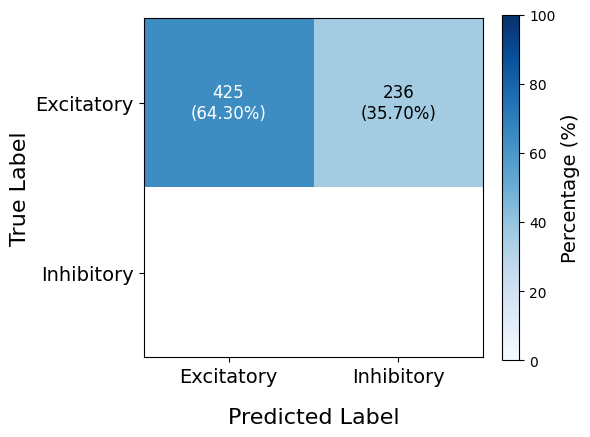

In [392]:
# Calculate confusion matrix
cm = confusion_matrix(y_eval, y_pred_eval_labels.squeeze())

# Normalize to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

# Normalize the confusion matrix for text color mapping
norm = Normalize(vmin=0, vmax=100)  # Ensure min is 0

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm_percentage, interpolation='nearest', cmap='Blues', norm = norm)  # Use the Blues colormap

# Add a color bar
cbar = plt.colorbar(im, ax=ax, fraction = 0.046)
cbar.set_ticks([0, 20, 40, 60, 80, 100])  # Ensure it runs from 0 to 100
cbar.set_label("Percentage (%)", fontsize=14)

# Set axis labels and titles
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))
ax.set_xticklabels(['Excitatory', 'Inhibitory'], fontsize = 14)
ax.set_yticklabels(['Excitatory', 'Inhibitory'], fontsize = 14)
plt.xlabel('Predicted Label', fontsize = 16, labelpad = 15)
plt.ylabel('True Label', fontsize = 16)
#plt.title('Confusion Matrix')

# Normalize the confusion matrix for text color mapping
norm = Normalize(vmin=0, vmax=100)  # Ensure min is 0

# Annotate the confusion matrix with numbers and percentages
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        raw_count = cm[i, j]
        percent = cm_percentage[i, j]
        text = f"{raw_count}\n({percent:.2f}%)"
        
        # Get the RGBA color from the colormap
        rgba = im.cmap(norm(percent))  # Ensure it returns an RGBA tuple
        
        if isinstance(rgba, tuple) and len(rgba) == 4:
            r, g, b, _ = rgba  # Extract RGB values
        else:
            print(f"Unexpected colormap output at ({i},{j}):", rgba)
            continue  # Skip this iteration if color extraction fails
        
        # Calculate brightness (luminance)
        brightness = 0.299 * r + 0.587 * g + 0.114 * b  # Perceived brightness
        
        # Choose text color based on brightness
        font_color = "black" if brightness > 0.5 else "white"
        
        # Place the text with the determined font color
        ax.text(j, i, text, ha='center', va='center', color=font_color, fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, f'LLSPIN_confusion_matrix_eval_{model_type}.png'), dpi=300)
plt.savefig(os.path.join(OUTPUT_PATH, f'LLSPIN_confusion_matrix_eval_{model_type}.pdf'), dpi=300, format = 'pdf')
plt.show()


(300, 9, 1)
torch.Size([300, 9])


/tmp/ipykernel_25806/4123051361.py:36: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:,:,0], x_samples, labels, show = False)


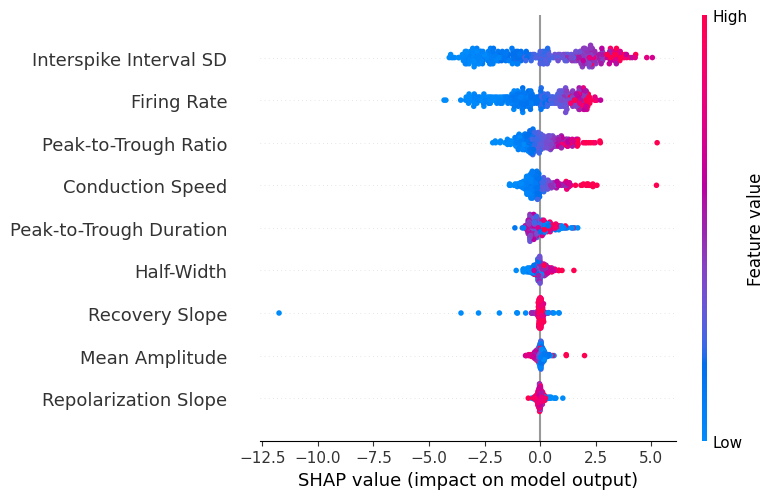

In [21]:
import shap
import torch
import tensorflow as tf 

# Ensure X_train is a NumPy array or PyTorch tensor
#X_train_tensor = torch.from_numpy(X_train).float().to(DEVICE)

features = ['firing_rate', 'peak_trough_ratio', 'peak_to_trough_duration', 'half_width', 'repolarization_slope', 'recovery_slope', 'speed_ms-1', 'isi_std', 'amplitude uV']
labels = ['Firing Rate', 'Peak-to-Trough Ratio', 'Peak-to-Trough Duration', 'Half-Width', 'Repolarization Slope', 'Recovery Slope', 'Conduction Speed', 'Interspike Interval SD', 'Mean Amplitude']

#features = ['Peak-to-Trough', 'Half-width', 'Repolarization slope', 'Recovery slope']

#features = ['Conduction Speed', 'FR', 'ISIstd', 'Mean_Amplitude']
#,  'Conduction Speed', 'Firing Rate', 'Interspike Interval SD', 'Mean Amplitude'

#features = ['Peak-to-Trough', 'Half-width', 'Repolarization slope', 'Conduction Speed', 'FR', 'ISIstd']

# Use a subset of the data for SHAP background
background_indices = torch.randint(0, len(standardized_X_train_tensor), (1000,))
background = standardized_X_train_tensor[background_indices]

# Initialize the SHAP explainer
explainer = shap.GradientExplainer(model, background)

# Select samples to explain
sample_indices= torch.randint(0, len(standardized_X_train_tensor), (300,))
x_samples = standardized_X_train_tensor[sample_indices]

# Calculate SHAP values
shap_values = explainer.shap_values(x_samples)

print(shap_values.shape)
print(x_samples.shape)

# Generate summary plot for the first output (e.g., class 0)
shap.summary_plot(shap_values[:,:,0], x_samples, labels, show = False)

#print(plot)
plt.savefig(os.path.join(OUTPUT_PATH,'LLSPIN_shap_summary_plot.pdf'), format='pdf', bbox_inches='tight', dpi=300)
plt.show()  # or plt.close() if you don't want to display

Different Day In Vitro

In [394]:
df = df_original[df_original['cell_type'] != 'CoCulture']
eval_divs = [49]

df_all_eval = df[df['chip_id'].isin([Chip_ID_ngn2[0], Chip_ID_ngn2[1], Chip_ID_gaba[0], Chip_ID_gaba[1]])]
df_all_eval = df_all_eval[df_all_eval['div'].astype(int).isin(eval_divs)]

df_all_eval['Type'] = df_all_eval['cell_type'].apply(lambda x: 0 if x == 'NGN2' else 1)


#df_1742 = pd.read_csv(dataset_path_1742)
#df_1742_divs = df_1742[df_1742['DIV'].isin(eval_divs)]

#df_all_eval = pd.concat([df_1742_divs], ignore_index=True)
 

df_relevant_eval = df_all_eval[['firing_rate', 'peak_trough_ratio', 'peak_to_trough_duration', 'half_width', 'repolarization_slope', 'recovery_slope', 'speed_ms-1', 'isi_std', 'amplitude uV']].copy()
# , 'Peak-to-Trough', 'Half-width', 'Repolarization slope', 'Recovery slope'
# , 'Conduction Speed', 'FR', 'ISIstd', 'Mean_Amplitude'
df_relevant_eval.replace('', np.nan, inplace=True)
df_relevant_eval.dropna(inplace = True)

In [ ]:
#dataset_path_DIV49 = f"/Volumes/violam/neuronies/single_neurons/3_Student_Projects/Amelie/Datasets/DIVS[49]_full_dataset.csv"

#df_DIV49 = pd.read_csv(dataset_path_DIV49)



X_eval_DIV49 = df_relevant_eval
y_eval_DIV49 = df_all_eval['Type']

X_tensor_DIV49 = torch.tensor(X_eval_DIV49.to_numpy(), dtype=torch.float32)

# Fit and transform the data
standardized_X_eval_DIV49 = scaler.transform(X_tensor_DIV49)

# Convert back to DataFrame for easier inspection
X_new_eval_DIV49 = pd.DataFrame(standardized_X_eval_DIV49, columns=X_eval_DIV49.columns)

# Convert DataFrame to PyTorch tensors
X_tensor_eval_DIV49 = torch.tensor(X_new_eval_DIV49.to_numpy(), dtype=torch.float32)
y_tensor_eval_DIV49 = torch.tensor(y_eval_DIV49.to_numpy(), dtype=torch.float32)

# set model to evaluation state
model.eval()

# Predict on the new dataset
with torch.no_grad():
    y_pred_eval_DIV49 = model(X_tensor_eval_DIV49)
    probabilities_DIV49 = torch.sigmoid(y_pred_eval_DIV49)
    y_pred_eval_labels_DIV49 = (probabilities_DIV49 > 0.5).int()

# Evaluate performance
accuracy = accuracy_score(y_tensor_eval_DIV49, y_pred_eval_labels_DIV49)
report_eval = classification_report(y_tensor_eval_DIV49, y_pred_eval_labels_DIV49, target_names=['Excitatory', 'Inhibitory'])
with open(os.path.join(OUTPUT_PATH, "classification_report_eval_newDIV.txt"), "w") as f:
    f.write(report_eval)
print(f"Accuracy on new dataset: {accuracy:.4f}")
print("Classification Report:")
print(report_eval)
print('Report saved')

ValueError: X has 9 features, but StandardScaler is expecting 4 features as input.

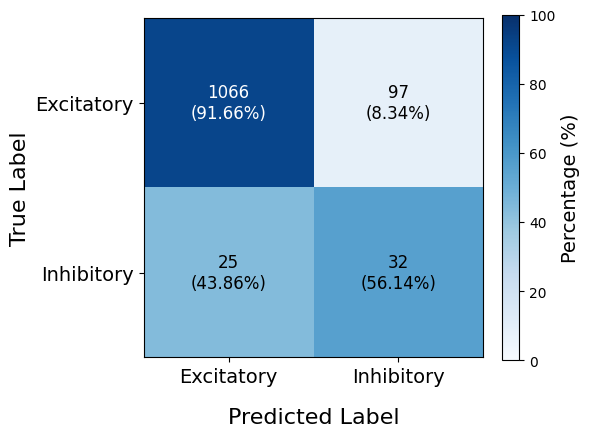

In [331]:
# Calculate confusion matrix
cm = confusion_matrix(y_eval_DIV49, y_pred_eval_labels_DIV49.squeeze())

# Normalize to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

# Normalize the confusion matrix for text color mapping
norm = Normalize(vmin=0, vmax=100)  # Ensure min is 0

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm_percentage, interpolation='nearest', cmap='Blues', norm = norm)  # Use the Blues colormap

# Add a color bar
cbar = plt.colorbar(im, ax=ax, fraction = 0.046)
cbar.set_ticks([0, 20, 40, 60, 80, 100])  # Ensure it runs from 0 to 100
cbar.set_label("Percentage (%)", fontsize=14)

# Set axis labels and titles
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))
ax.set_xticklabels(['Excitatory', 'Inhibitory'], fontsize = 14)
ax.set_yticklabels(['Excitatory', 'Inhibitory'], fontsize = 14)
plt.xlabel('Predicted Label', fontsize = 16, labelpad = 15)
plt.ylabel('True Label', fontsize = 16)
#plt.title('Confusion Matrix')

# Normalize the confusion matrix for text color mapping
norm = Normalize(vmin=0, vmax=100)  # Ensure min is 0

# Annotate the confusion matrix with numbers and percentages
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        raw_count = cm[i, j]
        percent = cm_percentage[i, j]
        text = f"{raw_count}\n({percent:.2f}%)"
        
        # Get the RGBA color from the colormap
        rgba = im.cmap(norm(percent))  # Ensure it returns an RGBA tuple
        
        if isinstance(rgba, tuple) and len(rgba) == 4:
            r, g, b, _ = rgba  # Extract RGB values
        else:
            print(f"Unexpected colormap output at ({i},{j}):", rgba)
            continue  # Skip this iteration if color extraction fails
        
        # Calculate brightness (luminance)
        brightness = 0.299 * r + 0.587 * g + 0.114 * b  # Perceived brightness
        
        # Choose text color based on brightness
        font_color = "black" if brightness > 0.5 else "white"
        
        # Place the text with the determined font color
        ax.text(j, i, text, ha='center', va='center', color=font_color, fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, f'LLSPIN_confusion_matrix_eval_newDIV_{model_type}.png'), dpi=300)
plt.savefig(os.path.join(OUTPUT_PATH, f'LLSPIN_confusion_matrix_eval_newDIV_{model_type}.pdf'), dpi=300, format = 'pdf')
plt.show()

In [34]:
import torch

# Assuming X_test and y_pred_test_labels are tensors
sorted_indices = torch.argsort(y_pred_test_labels.squeeze())

# Apply the sorted indices to X_test to reorder
sorted_X_test = X_test[sorted_indices]

# If you want to verify by adding the predicted labels back
sorted_X_test_with_labels = torch.cat((sorted_X_test, y_pred_test_labels[sorted_indices].view(-1, 1)), dim=1)

# Print the first and last few rows to confirm sorting
print(sorted_X_test_with_labels[:10])  # First 10 rows (predicted as label 0)
print(sorted_X_test_with_labels[-10:])  # Last 10 rows (predicted as label 1)

mask_0 = (y_pred_test_labels == 0).squeeze()  # Ensure it's shape [3366]
mask_1 = (y_pred_test_labels == 1).squeeze()

# Extract data for each cell type
X_test_0 = X_test[mask_0]  # Features for predicted label 0
X_test_1 = X_test[mask_1]  # Features for predicted label 1

print("Shape of X_test_0:", X_test_0.shape)
print("Shape of X_test_1:", X_test_1.shape)


# Compute mean per feature for each predicted cell type
mean_features_0 = X_test_0.mean(dim=0)  # Mean for cell type 0
mean_features_1 = X_test_1.mean(dim=0)  # Mean for cell type 1

# Print the results
print("Mean per feature for predicted cell type 0:\n", mean_features_0)
print("Mean per feature for predicted cell type 1:\n", mean_features_1)


tensor([[-3.7749e-02,  4.1500e-04,  9.2874e+04, -5.4788e+04,  2.2042e-01,
          6.3057e+00,  2.7051e-01, -8.6364e+01,  0.0000e+00],
        [-1.0775e-01,  2.8000e-04,  1.2702e+05, -1.1281e+04,  3.7664e-01,
          1.6901e+00,  6.4318e-01, -7.8860e+01,  0.0000e+00],
        [-1.0906e-01,  3.1500e-04,  1.4673e+05, -1.5794e+05,  2.8809e-01,
          5.9282e-01,  1.9858e+00, -8.6080e+01,  0.0000e+00],
        [-8.4121e-02,  4.1500e-04,  1.2453e+05, -2.7330e+03,  3.8507e-01,
          1.5136e+00,  7.6949e-01, -6.1111e+01,  0.0000e+00],
        [-3.0215e-01,  4.8500e-04,  2.9073e+05, -1.5934e+05,  2.7929e-01,
          1.8094e-01,  3.5627e+00, -1.8989e+02,  0.0000e+00],
        [-1.9368e-01,  5.4500e-04,  1.1164e+05, -6.3828e+03,  5.4234e-01,
          2.4604e+00,  4.8208e-01, -6.3167e+01,  0.0000e+00],
        [-1.8885e-01,  5.0500e-04,  8.8130e+04, -1.5180e+04,  2.9877e-01,
          5.9042e-01,  1.8209e+00, -5.7675e+01,  0.0000e+00],
        [-1.3309e-01,  3.3000e-04,  1.3280e+05, 

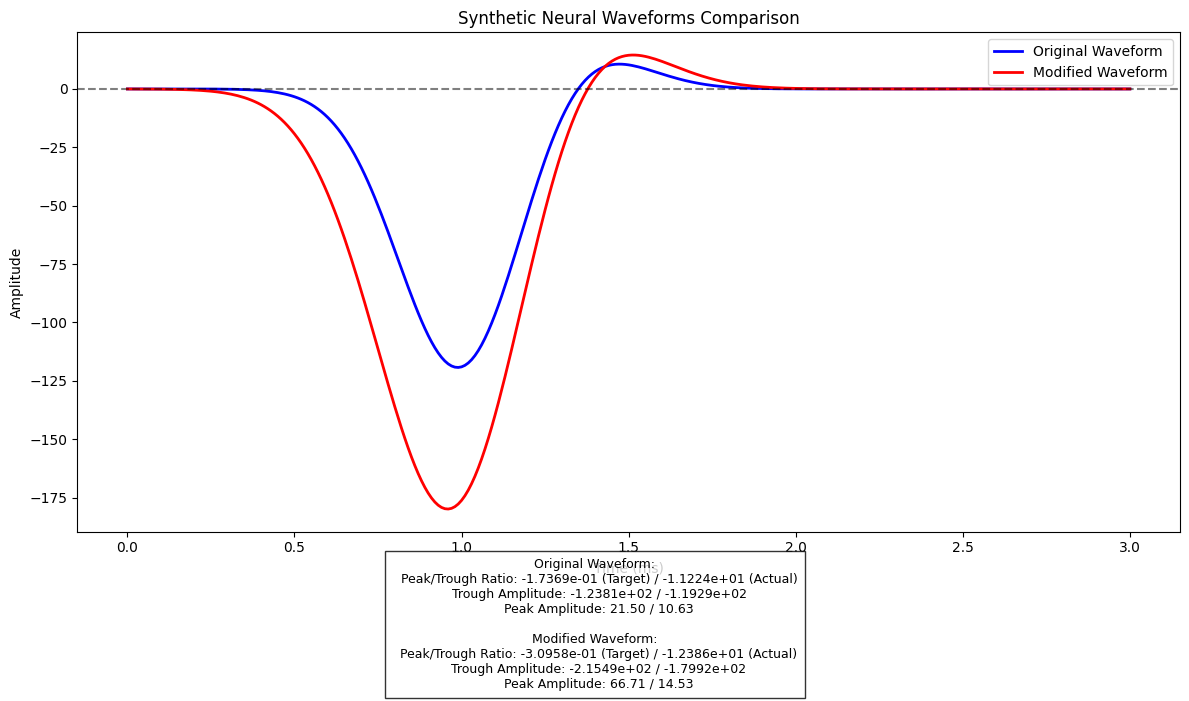

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_function(x, mu, sigma):
    """Create a Gaussian function."""
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def generate_synthetic_waveform(peak_to_trough_ratio, half_width_ms, repolarization_slope, 
                               recovery_slope, mean_trough_amplitude, 
                               time_shift=0.0):
    """
    Generate a synthetic neural waveform based on specified metrics.
    
    Parameters:
    -----------
    peak_to_trough_ratio : float
        Ratio of peak to trough amplitude (negative/positive)
    half_width_ms : float
        Half-width of waveform components in milliseconds
    repolarization_slope : float
        Slope from trough to baseline
    recovery_slope : float
        Slope from peak to baseline (negative because downward)
    mean_trough_amplitude : float
        Mean amplitude of the trough (negative value)
    time_shift : float, optional
        Shift the entire waveform by this amount (ms)
        
    Returns:
    --------
    tuple
        (time_array, amplitude_array, metrics_dict) - Arrays containing the waveform data and metrics
    """
    # Derived values
    peak_amplitude = abs(mean_trough_amplitude * peak_to_trough_ratio)
    
    # Time parameters
    time_step = 0.01  # ms
    total_time = 3.0  # ms
    time = np.arange(0, total_time + time_step, time_step)
    
    # Position of trough and peak
    trough_time = 1.0 + time_shift  # ms
    
    # Calculate transition times based on slopes
    rise_time = abs(mean_trough_amplitude + peak_amplitude) / repolarization_slope * 1000
    peak_time = trough_time + rise_time
    
    # Create sigma values for Gaussian functions
    sigma_trough = half_width_ms / 2
    sigma_peak = half_width_ms / 2
    
    # Create amplitude array using Gaussian functions
    trough_component = mean_trough_amplitude * gaussian_function(time, trough_time, sigma_trough)
    peak_component = peak_amplitude * gaussian_function(time, peak_time, sigma_peak)
    
    # Combine components
    amplitude = trough_component + peak_component
    
    # Calculate actual metrics from generated waveform for verification
    actual_trough_amp = np.min(amplitude)
    actual_peak_amp = np.max(amplitude)
    actual_peak_to_trough_ratio = actual_trough_amp / actual_peak_amp
    
    # Find indices for slope calculation
    trough_idx = np.argmin(amplitude)
    peak_idx = np.argmax(amplitude)
    
    # Calculate actual slopes
    midrise_idx = (trough_idx + peak_idx) // 2
    if midrise_idx > 0 and midrise_idx < len(amplitude) - 2:
        actual_repolarization_slope = (amplitude[midrise_idx+1] - amplitude[midrise_idx-1]) / (time[midrise_idx+1] - time[midrise_idx-1]) * 1000
    else:
        actual_repolarization_slope = np.nan
    
    fall_idx = min(peak_idx + 20, len(amplitude) - 3)
    if fall_idx > 0 and fall_idx < len(amplitude) - 2:
        actual_recovery_slope = (amplitude[fall_idx+1] - amplitude[fall_idx-1]) / (time[fall_idx+1] - time[fall_idx-1]) * 1000
    else:
        actual_recovery_slope = np.nan
    
    # Compile metrics
    metrics = {
        'target_peak_to_trough_ratio': peak_to_trough_ratio,
        'actual_peak_to_trough_ratio': actual_peak_to_trough_ratio,
        'half_width_ms': half_width_ms,
        'target_trough_amplitude': mean_trough_amplitude,
        'actual_trough_amplitude': actual_trough_amp,
        'target_peak_amplitude': peak_amplitude,
        'actual_peak_amplitude': actual_peak_amp,
        'target_repolarization_slope': repolarization_slope,
        'actual_repolarization_slope': actual_repolarization_slope,
        'target_recovery_slope': recovery_slope,
        'actual_recovery_slope': actual_recovery_slope
    }
    
    return time, amplitude, metrics

def plot_multiple_waveforms(waveforms, labels=None, colors=None, figsize=(12, 7), save_path=None):
    """
    Plot multiple waveforms on the same figure.
    
    Parameters:
    -----------
    waveforms : list of tuples
        List of (time, amplitude, metrics) tuples for each waveform
    labels : list of str, optional
        Labels for each waveform
    colors : list of str, optional
        Colors for each waveform
    figsize : tuple, optional
        Figure size (width, height)
    save_path : str, optional
        Path to save the figure
    """
    if labels is None:
        labels = [f"Waveform {i+1}" for i in range(len(waveforms))]
    
    if colors is None:
        colors = plt.cm.viridis(np.linspace(0, 0.9, len(waveforms)))
    
    plt.figure(figsize=figsize)
    
    # Plot each waveform
    for i, (time, amplitude, metrics) in enumerate(waveforms):
        plt.plot(time, amplitude, color=colors[i], linewidth=2, label=labels[i])
    
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    #plt.grid(True, alpha=0.3)
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    plt.title('Synthetic Neural Waveforms Comparison')
    plt.legend()
    
    # Add metrics to the plot
    metrics_text = []
    for i, (_, _, metrics) in enumerate(waveforms):
        text = f"{labels[i]}:\n"
        text += f"  Peak/Trough Ratio: {metrics['target_peak_to_trough_ratio']:.4e} (Target) / {metrics['actual_peak_to_trough_ratio']:.4e} (Actual)\n"
        text += f"  Trough Amplitude: {metrics['target_trough_amplitude']:.4e} / {metrics['actual_trough_amplitude']:.4e}\n"
        text += f"  Peak Amplitude: {metrics['target_peak_amplitude']:.2f} / {metrics['actual_peak_amplitude']:.2f}"
        metrics_text.append(text)
    
    plt.figtext(0.5, 0.01, "\n\n".join(metrics_text), ha='center', fontsize=9, 
                bbox={"facecolor":"white", "alpha":0.8, "pad":5})
    
    plt.tight_layout(rect=[0, 0.15, 1, 1])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# Example usage with two different waveforms
if __name__ == "__main__":
    # First waveform (your original metrics)
    metrics1 = {
        'peak_to_trough_ratio': -1.7369e-01,  # negative/positive ratio
        'half_width_ms': 3.7208e-01,  # ms
        'repolarization_slope': 3.1702e+05,  # from trough to baseline
        'recovery_slope': -5.1545e+04,  # from peak to baseline (negative because downward)
        'mean_trough_amplitude': -1.2381e+02  # mean trough amplitude
    }
    
    # Second waveform (example with different metrics)
    metrics2 = {
        'peak_to_trough_ratio': -3.0958e-01,  # negative/positive ratio
        'half_width_ms': 4.5679e-01,  # ms
        'repolarization_slope': 6.3274e+05,  # from trough to baseline
        'recovery_slope': -1.6625e+05,  # from peak to baseline (negative because downward)
        'mean_trough_amplitude': -2.1549e+02  # mean trough amplitude
    }
    
    # Generate waveforms
    waveform1 = generate_synthetic_waveform(**metrics1)
    waveform2 = generate_synthetic_waveform(**metrics2, time_shift=0.0)  # Same time position
    
    # Plot both waveforms together
    plot_multiple_waveforms(
        [waveform1, waveform2],
        labels=["Original Waveform", "Modified Waveform"],
        colors=['blue', 'red'],
        save_path="comparison_waveforms.png"
    )
    
    # Save the data for later use
    np.savez("waveform_comparison.npz", 
             waveform1_time=waveform1[0], 
             waveform1_amplitude=waveform1[1],
             waveform2_time=waveform2[0], 
             waveform2_amplitude=waveform2[1])
    

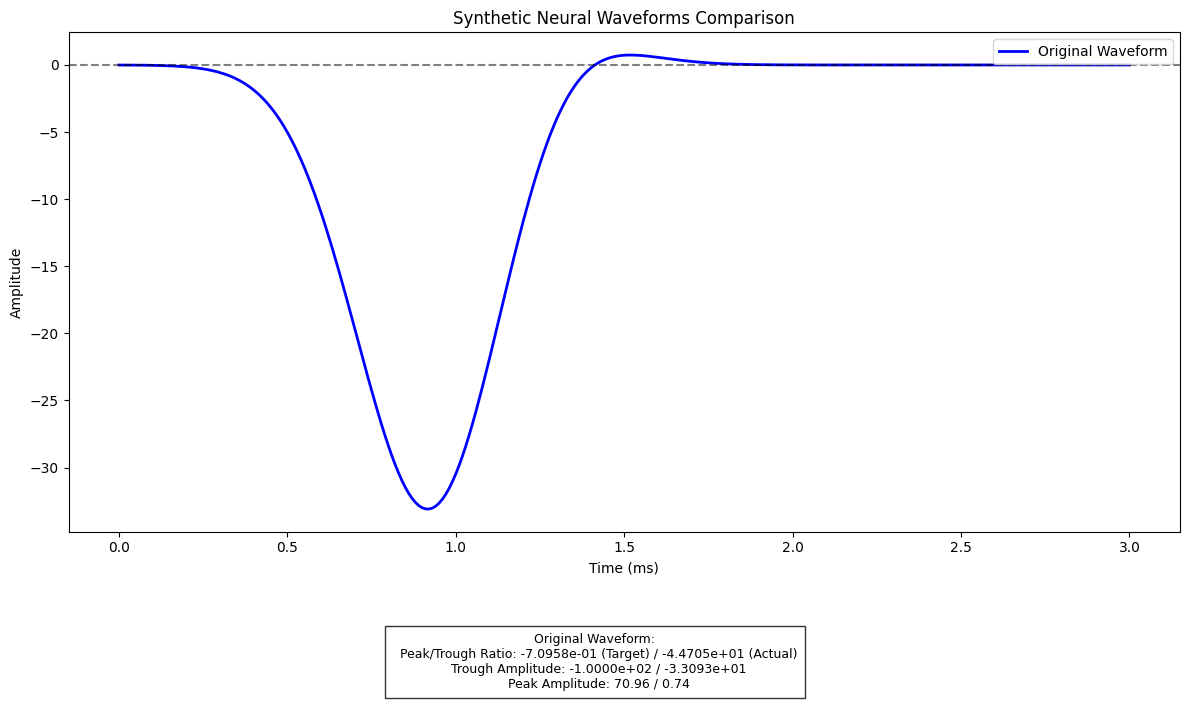

In [ ]:
metrics = {
        'peak_to_trough_ratio': -7.0958e-01,  # negative/positive ratio
        'half_width_ms': 4.5679e-01,  # ms
        'repolarization_slope': 6.3274e+05,  # from trough to baseline
        'recovery_slope': -1.6625e+05,  # from peak to baseline (negative because downward)
        'mean_trough_amplitude': -2.1549e+02  # mean trough amplitude
    }

waveform = generate_synthetic_waveform(**metrics)

plot_multiple_waveforms(
        [waveform],
        labels=["Original Waveform"],
        colors=['blue']
    )

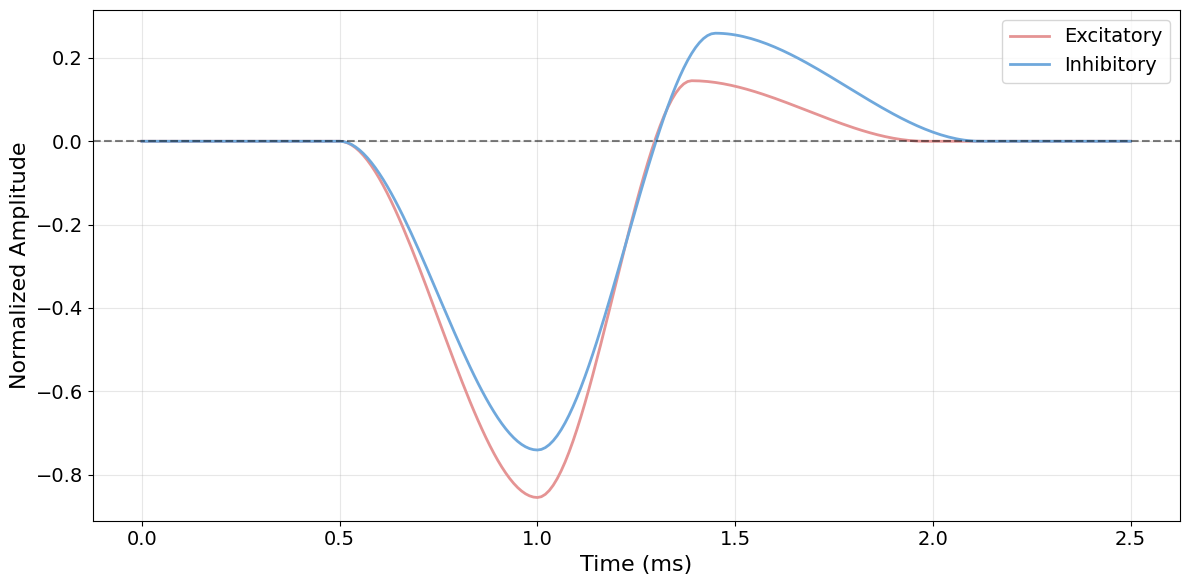

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def generate_realistic_waveform(peak_to_trough_ratio, half_width_ms, repolarization_slope, 
                              recovery_slope, time_shift=0.0):
    """
    Generate a synthetic neural waveform that resembles realistic extracellular recordings
    with negative trough first, normalized so the peak-to-trough amplitude equals 1.
    
    Parameters:
    -----------
    peak_to_trough_ratio : float
        Ratio of peak amplitude to trough amplitude (absolute value)
    half_width_ms : float
        Half-width of waveform in milliseconds
    repolarization_slope : float
        Slope from trough to peak (rising phase)
    recovery_slope : float
        Slope from peak back to baseline (falling phase)
    time_shift : float, optional
        Shift the entire waveform by this amount (ms)
        
    Returns:
    --------
    tuple
        (time_array, normalized_amplitude_array, metrics_dict) - Arrays containing the waveform data and metrics
    """
    # Time parameters
    time_step = 0.01  # ms
    total_time = 2.5  # ms
    time = np.arange(0, total_time + time_step, time_step)
    
    # Baseline position
    baseline = 0.0
    
    # Position of key waveform features
    baseline_start = 0.5 + time_shift  # ms
    trough_time = 1.0 + time_shift  # ms
    rise_duration = half_width_ms  # Time to rise from trough to peak
    peak_time = trough_time + rise_duration  # Peak follows trough
    recovery_duration = half_width_ms * 1.5  # Time to return to baseline
    baseline_end = peak_time + recovery_duration  # ms
    
    # Create empty amplitude array
    amplitude = np.zeros_like(time) + baseline
    
    # Generate indices for different parts of the waveform
    baseline_start_idx = np.argmin(np.abs(time - baseline_start))
    trough_idx = np.argmin(np.abs(time - trough_time))
    peak_idx = np.argmin(np.abs(time - peak_time))
    baseline_end_idx = np.argmin(np.abs(time - baseline_end))
    
    # Initial amplitudes (will be normalized later)
    # Set trough to -0.5 and peak will be +0.5 based on ratio
    # This gives us a total peak-to-trough amplitude of 1
    trough_amplitude = -0.5
    peak_amplitude = abs(trough_amplitude) * peak_to_trough_ratio
    
    # Apply slope from baseline to trough (falling to trough)
    for i in range(baseline_start_idx, trough_idx):
        progress = (i - baseline_start_idx) / max(1, (trough_idx - baseline_start_idx))
        # Use cubic function for more natural descent
        amplitude[i] = baseline + trough_amplitude * (3 * (progress ** 2) - 2 * (progress ** 3))
    
    # Apply repolarization slope (rising from trough to peak)
    for i in range(trough_idx, peak_idx):
        progress = (i - trough_idx) / max(1, (peak_idx - trough_idx))
        # Use cubic function for more natural rise
        amplitude[i] = trough_amplitude + (peak_amplitude - trough_amplitude) * (3 * (progress ** 2) - 2 * (progress ** 3))
    
    # Apply recovery slope (falling from peak to baseline)
    for i in range(peak_idx, baseline_end_idx):
        progress = (i - peak_idx) / max(1, (baseline_end_idx - peak_idx))
        # Use cubic function for more natural recovery
        amplitude[i] = peak_amplitude + (baseline - peak_amplitude) * (3 * (progress ** 2) - 2 * (progress ** 3))
    
    # Normalize so the peak-to-trough difference equals exactly 1
    actual_trough = np.min(amplitude)
    actual_peak = np.max(amplitude)
    current_range = actual_peak - actual_trough
    
    # Scale to make peak-to-trough difference = 1
    normalized_amplitude = amplitude / current_range
    
    # Shift so the baseline is at zero
    baseline_value = (normalized_amplitude[baseline_start_idx] + 
                      normalized_amplitude[baseline_end_idx]) / 2
    normalized_amplitude = normalized_amplitude - baseline_value
    
    # Recalculate metrics for verification
    actual_trough_amp = np.min(normalized_amplitude)
    actual_peak_amp = np.max(normalized_amplitude)
    actual_peak_to_trough_diff = actual_peak_amp - actual_trough_amp
    actual_peak_to_trough_ratio = actual_peak_amp / abs(actual_trough_amp)
    
    # Find indices for slope calculation
    trough_idx = np.argmin(normalized_amplitude)
    peak_idx = np.argmax(normalized_amplitude)
    
    # Calculate actual slopes
    # For repolarization (trough to peak)
    rise_mid_idx = (trough_idx + peak_idx) // 2
    if rise_mid_idx > 0 and rise_mid_idx < len(normalized_amplitude) - 2:
        actual_repolarization_slope = (normalized_amplitude[rise_mid_idx+1] - 
                                      normalized_amplitude[rise_mid_idx-1]) / (time[rise_mid_idx+1] - time[rise_mid_idx-1])
    else:
        actual_repolarization_slope = np.nan
    
    # For recovery (peak to baseline)
    recovery_mid_idx = peak_idx + (baseline_end_idx - peak_idx) // 3
    if recovery_mid_idx > 0 and recovery_mid_idx < len(normalized_amplitude) - 2:
        actual_recovery_slope = (normalized_amplitude[recovery_mid_idx+1] - 
                               normalized_amplitude[recovery_mid_idx-1]) / (time[recovery_mid_idx+1] - time[recovery_mid_idx-1])
    else:
        actual_recovery_slope = np.nan
    
    # Calculate half-width
    half_amp = (actual_peak_amp + actual_trough_amp) / 2
    above_half = normalized_amplitude > half_amp
    if np.any(above_half):
        crosses = np.diff(above_half.astype(int))
        cross_indices = np.where(crosses != 0)[0]
        if len(cross_indices) >= 2:
            actual_half_width = time[cross_indices[1]] - time[cross_indices[0]]
        else:
            actual_half_width = np.nan
    else:
        actual_half_width = np.nan
    
    # Compile metrics
    metrics = {
        'target_peak_to_trough_ratio': peak_to_trough_ratio,
        'actual_peak_to_trough_ratio': actual_peak_to_trough_ratio,
        'peak_to_trough_amplitude': actual_peak_to_trough_diff,
        'half_width_ms': half_width_ms,
        'actual_half_width_ms': actual_half_width,
        'actual_trough_amplitude': actual_trough_amp,
        'actual_peak_amplitude': actual_peak_amp,
        'target_repolarization_slope': repolarization_slope,
        'actual_repolarization_slope': actual_repolarization_slope * 1000,  # Convert to ms^-1
        'target_recovery_slope': recovery_slope,
        'actual_recovery_slope': actual_recovery_slope * 1000  # Convert to ms^-1
    }
    
    return time, normalized_amplitude, metrics

def plot_multiple_waveforms(waveforms, labels=None, colors=None, figsize=(12, 7), save_path=None):
    """
    Plot multiple normalized waveforms on the same figure.
    
    Parameters:
    -----------
    waveforms : list of tuples
        List of (time, normalized_amplitude, metrics) tuples for each waveform
    labels : list of str, optional
        Labels for each waveform
    colors : list of str, optional
        Colors for each waveform
    figsize : tuple, optional
        Figure size (width, height)
    save_path : str, optional
        Path to save the figure
    """
    if labels is None:
        labels = [f"Waveform {i+1}" for i in range(len(waveforms))]
    
    if colors is None:
        colors = plt.cm.viridis(np.linspace(0, 0.9, len(waveforms)))
    
    plt.figure(figsize=figsize)
    
    # Plot each waveform
    for i, (time, amplitude, metrics) in enumerate(waveforms):
        plt.plot(time, amplitude, color=colors[i], linewidth=2, label=labels[i])
    
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    plt.grid(True, alpha=0.3)
    plt.xlabel('Time (ms)', fontsize = 16)
    plt.ylabel('Normalized Amplitude', fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    #plt.title('Realistic Extracellular Neural Waveforms')
    plt.legend(fontsize = 14)
    
    # # Add metrics to the plot
    # metrics_text = []
    # for i, (_, _, metrics) in enumerate(waveforms):
    #     text = f"{labels[i]}:\n"
    #     text += f"  Peak/Trough Ratio: {metrics['target_peak_to_trough_ratio']:.2f} (Target) / {metrics['actual_peak_to_trough_ratio']:.2f} (Actual)\n"
    #     text += f"  Peak-to-Trough Amplitude: {metrics['peak_to_trough_amplitude']:.2f}\n"
    #     text += f"  Half-width: {metrics['half_width_ms']:.2f} ms (Target) / {metrics['actual_half_width_ms']:.2f} ms (Actual)\n"
    #     text += f"  Trough Amplitude: {metrics['actual_trough_amplitude']:.2f}\n"
    #     text += f"  Peak Amplitude: {metrics['actual_peak_amplitude']:.2f}"
    #     metrics_text.append(text)
    
    # plt.figtext(0.5, 0.01, "\n\n".join(metrics_text), ha='center', fontsize=9, 
    #             bbox={"facecolor":"white", "alpha":0.8, "pad":5})
    
    plt.tight_layout(rect=[0, 0.15, 1, 1])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# Example usage
if __name__ == "__main__":
    # Example waveform 1 - Typical extracellular spike
    metrics1 = {
        'peak_to_trough_ratio': 0.17,  # positive ratio for excitatory
        'half_width_ms': 0.39,  # ms
        'repolarization_slope': 2.45,  # relative value
        'recovery_slope': -4.40  # relative value
    }
    
    # Second waveform - inhibitory (modified to ensure positive peak)
    metrics2 = {
        'peak_to_trough_ratio': 0.35,  # positive ratio for inhibitory (but larger)
        'half_width_ms': 0.45,  # ms
        'repolarization_slope': 6.57,  # relative value
        'recovery_slope': -1.50  # relative value
    }
    
    # Generate waveforms
    waveform1 = generate_realistic_waveform(**metrics1)
    waveform2 = generate_realistic_waveform(**metrics2, time_shift=0.0)
    
    # Plot waveforms
    plot_multiple_waveforms(
        [waveform1, waveform2],
        labels=["Excitatory", "Inhibitory"],
        colors=['#e59494', '#6fa8dc'],
        save_path="/Volumes/violam/neuronies/single_neurons/3_Student_Projects/Amelie/Figures/LLSPIN/Best_performance_waveforms/generated_extracellular_waveforms.svg"
    )
    